In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff6_1 as ds
from copy import copy as dup
from scipy.integrate import odeint

In [2]:
# Graphics parameters
%matplotlib notebook
ticklabelsize = 11
fontsize = 15
linewidth = 2
fignum = 0

### The cell below specifies parameters for the 0-d and 1-d runs

<IPython.core.display.Javascript object>


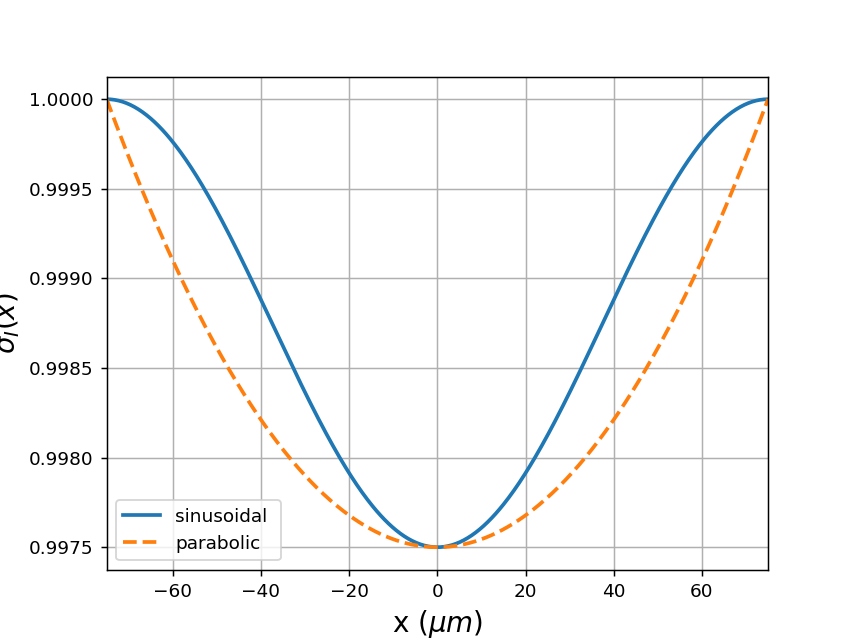

0.8333333333333334
sinusoid: 1136.3926987480681
paraboloic: 1051.1202766185813
D = 5e-05 um^2/us 0.05 x 10^-9 m^2/sec
deltat_max (Diffusion time) = 1799.9999999999998
deltat = 35.99999999999999
deprate = 0.8333333333333334 monolayers/us
nmid = 250
N* = 0.1432394487827058
N*x2pi = 0.9
Nbar, Nbar-N*, N*/Nbar = 1.0 0.8567605512172942 0.1432394487827058
deltax = 0.3
sigma_0 = 0.19
sigmaIcorner = 0.22
center reduction = 0.25 %
c_r = 0.0025 dimensionless
max growth rate = 55.00000000000001 um/sec
min growth rate = 7.5 um/sec
nu_kin = 250 um/sec
dx = 0.3
L = 75.0 micrometers


In [3]:
#Setting up the system
nx = 501 # Number of points in simulation box
# nx = 1501 # Number of points in simulation box
xmax = 50
xmax = 150
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltax = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot = np.ones(nx)
NQLL = ds.getNliq(Ntot,Nstar,Nbar)
Nice = Ntot-NQLL

# Lay out the system
Ntot = NQLL + Nice
nmid = int(nx/2)
nquart = int(nx/4)
xmid = max(x)/2
xmax = x[nx-1]
Nice_start = Nice[0]

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
# D = 2e-4 # micrometers^2/microsecond
D = 1.6e-4 # micrometers^2/microsecond
D = 5e-5 # micrometers^2/microsecond
# D = 8e-6 # micrometers^2/microsecond
# D = 2e-7 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 50
dtmax = deltax**2/D
deltat = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 34 # microns/second - about right for 240 K
nu_kin = 49 # microns/second - between 240 and 260 K
nu_kin = 250 # microns/second - about right for 260 K
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltat = deprate * deltat

# Supersaturation
sigma0 = 0.19
sigmaIcorner = 0.20 # Must be bigger than sigma0 to get growth
sigmaIcorner = 0.22 # Must be bigger than sigma0 to get growth
center_reduction = 0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
Doverdeltax2 = D/deltax**2

# Gets the function sigma(x)
sigmaI_sinusoid = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='sinusoid') #NOTE i think this should be nx not xmax
sigmaI_parabolic = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='parabolic')
sigmaIstyle = 'sinusoid'
# sigmaIstyle = 'parabolic'
if sigmaIstyle=='sinusoid':
    sigmaI = sigmaI_sinusoid
elif sigmaIstyle=='parabolic':
    sigmaI = sigmaI_parabolic
else:
    print('bad choice')

# Graph sigma(x)
plt.figure()
plt.plot(x-xmid,sigmaI_sinusoid/sigmaIcorner, \
         x-xmid, sigmaI_parabolic/sigmaIcorner, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

# These are run control parameters

# Flag for explicit updating NQLL(Ntot) every step
updatingNQLL = False

# Set up a maximum number of iterations or layers
uselayers = True

# 0D run
if uselayers:
    layermax_0D = 100
else:
    countermax_0D = 100

# 1D run 
if uselayers:
    layermax_1D = 2500
else:
    countermax_1D = 15000

#Parameters for 1-D run 
L = xmax/2
c_r = center_reduction / 100; 
nu_kin_ml = deprate; print(nu_kin_ml) # monolayers per microsecond
# sigma_I = sigmaIcorner; print('sigmaI ', sigma_I) # dimensionless
M = np.array([.0027, .0025])
B = np.array([2.9, 1.59])
beta = np.array([0.65, 0.65])
xfactor = nu_kin_ml*L**2*c_r**beta*sigmaIcorner/D
NSS = M*xfactor + B
print('sinusoid:', NSS[0])
print('paraboloic:', NSS[1])
    
# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltat_max (Diffusion time) =', dtmax)
print('deltat =', deltat)
print('deprate =', deprate, 'monolayers/us')
print('nmid =', nmid)
print('N* =', Nstar)
print('N*x2pi =', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar =', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltax =', deltax)
print('sigma_0 =', sigma0)
print('sigmaIcorner =', sigmaIcorner)
print('center reduction =', center_reduction, '%')
print('c_r =', c_r, 'dimensionless')
print('max growth rate =', deprate*sigmaIcorner*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', deprate*(sigmaIcorner-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')
print('dx =', deltax)
print('L =', L, 'micrometers')

### This is the 0-d run

In [4]:
# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmaIcorner, sigma0, deprate]

y0 = [Nbar,0.0]
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltat]

# Initialize the keeper arrays
tkeep_0D = [t0]
ykeep_0D = [y0]
tlast = dup(t0)
Nicelast0 = 0.0
Ntotlast0 = 0.0
Nicelast_start = 0.0
Ntotlast_start = 0.0

# Call the ODE solver
counter = 0
layer = 0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,),rtol=1e-12)
    ylast = list(y[1,:])
    tlast += deltat
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Make some local copies, with possible updates to NQLL
    NQLLlast, Ntotlast = ylast
    Nicelast = Ntotlast - NQLLlast
    Nicelast0 = dup(Nicelast)
    Ntotlast0 = dup(Ntotlast)
    
    # Update counters and see whether to break
    counter += 1
    layer = dup(Ntotlast0) 
    if uselayers:
        if layer > layermax_0D-1:
            break
    else:
        if counter > countermax_0D-1:
            break
    
# Convert results to a numpy array
ykeep_0Darr = np.array(ykeep_0D, np.float64)
tkeep_0Darr = np.array(tkeep_0D, np.float64)

0-D Modeled growth rate, um/s 17.862574645071533
0-D Modeled growth rate, ml/us 0.05954191548357178
0-D Modeled alpha 0.32477408445584605


<IPython.core.display.Javascript object>


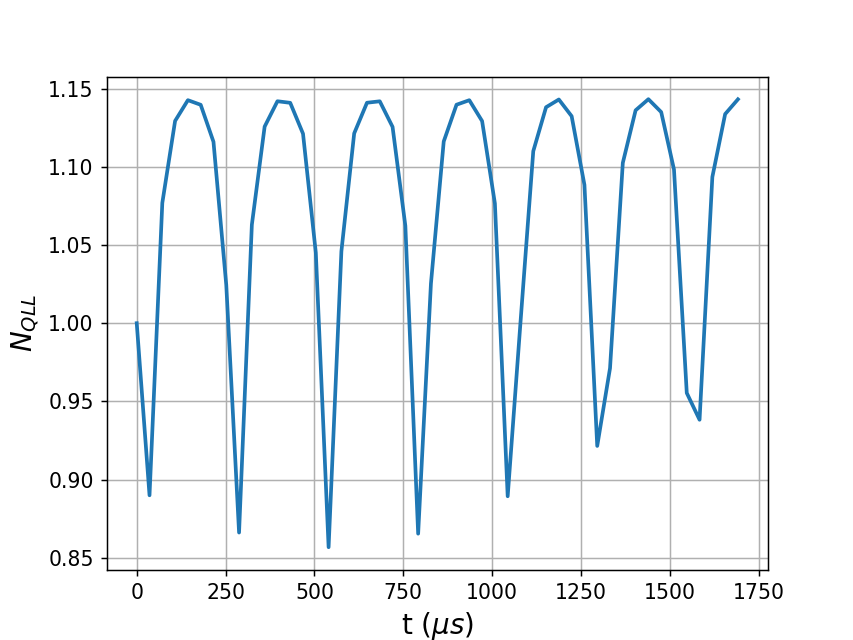

In [5]:
# Growth statistics
delta_Ntot_0d = Ntotlast0-Ntotlast_start
growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d_mlyperus)
alpha_0d = growthrate_0d/nu_kin/sigmaIcorner
print( "0-D Modeled alpha", alpha_0d)

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')


### This is the 1-d run

In [6]:
# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmaI, sigma0, deprate, Doverdeltax2, nx] 

# Initial conditions for ODE solver
y0 = np.array([NQLL,Ntot])
ylast = dup(y0)

# Initialize the keeper arrays
tkeep = [t0]
Nicekeep = [dup(Nice)]
Ntotkeep = [dup(Ntot)]
NQLLkeep = [dup(NQLL)]
fluxderivskeep = []

# Call the ODE solver
Nice0_start = Nice[0]
Nice0 = Nice[0]
Ntot0_start = Ntot[0]
Ntot0 = Ntot[0]
counter = 0
lastlayer = 0
lastdiff = 0

while True:
    # Integrate up to next time step
    y = odeint(ds.f1d, np.reshape(ylast,2*nx), tinterval, args=(params,),rtol=1e-12)

    ylast = np.reshape(y[1],(2,nx))
    tlast += deltat
    counter += 1
        
    # Make some local copies, with possible updates to NQLL
    NQLL, Ntot = ylast
    Nice = Ntot - NQLL
    Nice0 = Nice[0]
    Ntot0 = Ntot[0]
    ttot += deltat

    # Stuff into keeper arrays
    Nicekeep.append(Nice)
    Ntotkeep.append(Ntot)
    NQLLkeep.append(NQLL)
    tkeep.append(ttot)

    # Update counters and see whether to break
    layer = Ntot0-Ntot0_start
    if (layer-lastlayer) > 0:
        minpoint = min(Nice)
        maxpoint = max(Nice)
        print(counter-1, int(layer), maxpoint-minpoint)
        lastdiff = maxpoint-minpoint
        lastlayer += 1
    if uselayers:
        if layer > layermax_1D-1:
            print('breaking because reached max number of layers')
            break
    else:
        if counter > countermax_1D-1:
            print('breaking because reached max number of iterations')
            break

0 2 0.036425957097570016
1 4 0.008467803865944923
2 6 0.01851474667968489
3 8 0.0279260077032788
4 10 0.044591671167461655
5 12 0.08646827735038976
6 14 0.23145924001036455
7 17 0.5867905534209257
8 19 0.2988187793643675
9 21 0.05149200240088092
10 23 0.0705109580538803
11 25 0.09085727925189957
12 27 0.13676760187949455
13 29 0.2820392431072847
14 32 0.7180704875648125
15 34 0.7371672668600624
16 36 0.5551849734305065
17 38 0.15875672935639074
18 40 0.12581599144150601
19 42 0.17399580137323767
20 44 0.30206146374767684
21 47 0.7269175716813834
22 49 0.857704477202816
23 51 0.820984414441341
24 53 0.7275454841285836
25 55 0.43036593339443385
26 57 0.19927850296593164
27 59 0.31669123552148193
28 62 0.6997795887657219
29 64 0.9194786976340197
30 66 0.9086918519959255
31 68 0.8945972707882817
32 70 0.8494448872679641
33 72 0.7036468820229089
34 74 0.388580772638619
35 77 0.6568623424902142
36 79 0.9665245415370265
37 81 0.9612500572557678
38 83 0.963518834708438
39 85 0.9629200729442289

/Users/nesh/anaconda3/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


42 91 0.9687023118996905
43 93 0.9890840100990346
44 95 1.036099805842639
45 98 1.1321728876224029
46 100 1.225325636832011
47 102 1.169003575141403
48 104 1.067369899513892
49 106 1.0284686023503156
50 108 1.0279476453894887
51 110 1.0376494508508074
52 112 1.0473658990066923
53 114 1.0568348157345326
54 116 1.0661227186227222
55 118 1.0766266064268564
56 120 1.091137787531082
57 122 1.1121822791927087
58 124 1.1470948781829122
59 126 1.1976009837455877
60 128 1.2864838088511732
61 131 1.4403178059409072
62 133 1.6821416955779966
63 135 1.8103501295470608
64 137 1.8196886099524363
65 139 1.804248893779743
66 141 1.7880522312250378
67 143 1.7661590069477882
68 145 1.7347013034840586
69 147 1.6850400944676096
70 149 1.611086584222221
71 151 1.5002291920474704
72 153 1.3633213225099894
73 155 1.2449494003923007
74 157 1.2090211423333983
75 159 1.2353296982797133
76 161 1.2980686688936203
77 163 1.3922369828763408
78 166 1.6286906190185846
79 168 1.847780414602198
80 170 1.938162508205096

353 730 3.0835252321934377
354 732 3.0879563674376413
355 734 3.093086902098662
356 736 3.096250448032947
357 738 3.101128838977843
358 740 3.1089793207230514
359 742 3.124219241002038
360 744 3.1449615868258434
361 746 3.17609253231592
362 748 3.2239769254365456
363 751 3.313298186902557
364 753 3.4365082148735837
365 755 3.546856167715532
366 757 3.5705145843218133
367 759 3.4675817503255075
368 761 3.2761368828282684
369 763 3.089028732530437
370 765 3.025511244245081
371 767 3.0239012601331297
372 769 3.0250116070470767
373 771 3.0236939305569877
374 773 3.021137950698858
375 775 3.018163991773008
376 777 3.0152438734787665
377 779 3.011989618895086
378 781 3.0083629057610324
379 783 3.003961093266639
380 785 2.998180039287149
381 787 2.9897649227233387
382 789 2.9767908254227677
383 791 2.9548781230976147
384 793 2.9074082440106395
385 795 2.8258367161070055
386 797 2.7006637844408488
387 800 2.6331883156702816
388 802 2.735927963371637
389 804 2.8819140712270155
390 806 2.9563380

653 1349 2.3731237192685057
654 1351 2.2201317065141666
655 1353 2.13853573410006
656 1355 2.126085842718794
657 1357 2.1411804124445553
658 1359 2.161833287267882
659 1361 2.1888723899119213
660 1363 2.226364316716854
661 1365 2.2833275444527317
662 1367 2.3966961503347193
663 1369 2.5784302467252473
664 1371 2.7914468532521823
665 1373 2.8931833049011857
666 1375 2.9020194322197312
667 1377 2.89766326792369
668 1379 2.8939631270261543
669 1381 2.890217122659351
670 1383 2.885656839495823
671 1385 2.8783179420722718
672 1387 2.859692538224863
673 1389 2.8340997865070676
674 1391 2.797990147412065
675 1393 2.7474003572422134
676 1396 2.6592542194039197
677 1398 2.538698588627767
678 1400 2.428429001110544
679 1402 2.426379294638309
680 1404 2.546367553715527
681 1406 2.769941268434877
682 1408 2.93872894819242
683 1410 2.977949235474398
684 1412 2.9777043344747653
685 1414 2.9774446095582334
686 1416 2.979389199516845
687 1418 2.9824916100808423
688 1420 2.985938492949572
689 1422 2.98

953 1963 2.7502339553384445
954 1965 2.680337581077538
955 1967 2.5650611942194246
956 1970 2.380611648953618
957 1972 2.1733406621997347
958 1974 2.0926955549473405
959 1976 2.0919902326998
960 1978 2.0950149254251755
961 1980 2.0960493350601155
962 1982 2.097667213786508
963 1984 2.10035617710696
964 1986 2.107901666973703
965 1988 2.1206401828319486
966 1990 2.1354525356946397
967 1992 2.1625245006343903
968 1994 2.1972488948715636
969 1996 2.249383555965778
970 1998 2.3345070059447153
971 2000 2.4175401211136887
972 2002 2.4325503697821205
973 2005 2.3035082943440557
974 2007 2.104456654068599
975 2009 2.0160580438569013
976 2011 2.0078906565372563
977 2013 2.0061268142762856
978 2015 2.0021674492882084
979 2017 1.9971043134260071
980 2019 1.9915452070879383
981 2021 1.9854787517997465
982 2023 1.9785949913969034
983 2025 1.970258804377636
984 2027 1.9595851209430748
985 2029 1.9447295290087823
986 2031 1.9232234054936725
987 2033 1.8908911472433374
988 2035 1.8367896289182681
989 

Height of Ice 0
1-D growth, corner 2499.8014721854465
1-D growth, center 2497.006264197287
1-D Modeled growth rate, corner, um/s 17.202047014763604
1-D Modeled growth rate, corner, ml/us 0.05734015671587868
1-D Modeled growth rate, center, um/s 17.182812167611388
1-D Modeled alpha, corner 0.31276498497220523
1-D Modeled alpha, center 0.31319776108655983
Difference, % 0.13837102461871328
0-D Modeled growth rate, um/s 17.862574645071533
0-D Modeled growth rate, ml/us 0.059541915483571774
0-D Modeled alpha 0.32477408445584605
Growth ratio 1D (corner)/0D 0.9630217007664024
Growth ratio 1D (center)/0D 0.9619448768743033
Contribution of diffusion -3.8055123125696664 %
Libbrecht's predicted growth rate, um/s 10.705216497342732
Libbrecht's predicted alpha 0.19464029995168605
Time taken: 0 min 0.00039386749267578125 secs


<IPython.core.display.Javascript object>


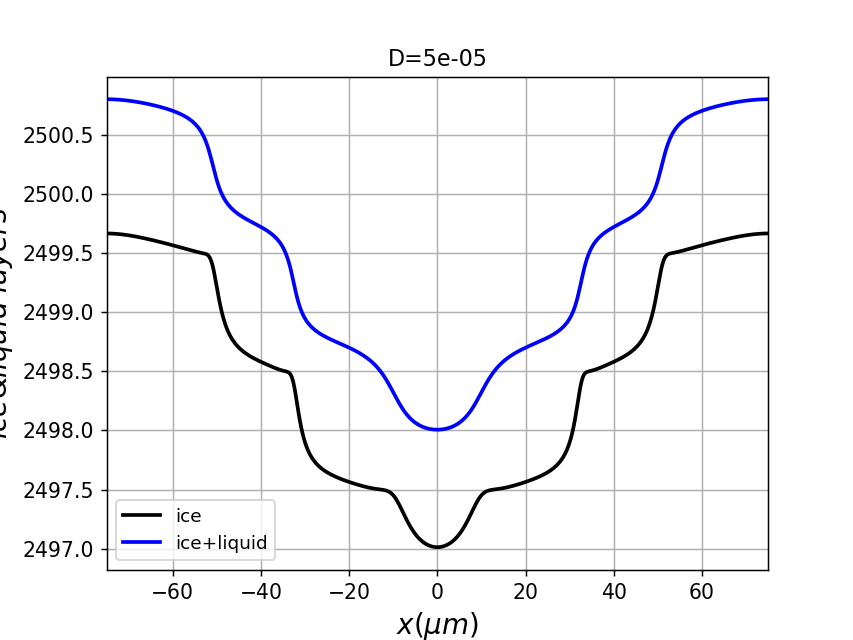

<IPython.core.display.Javascript object>


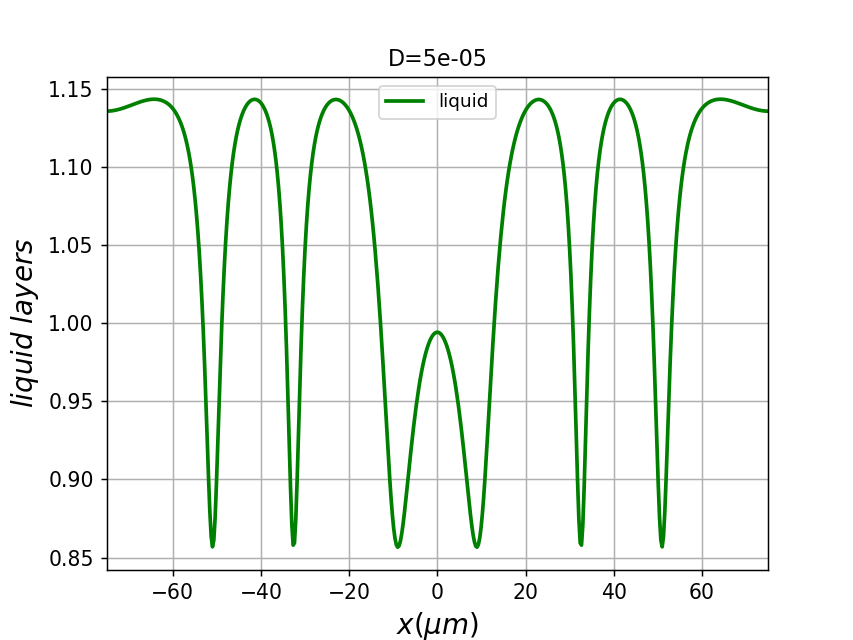

<IPython.core.display.Javascript object>


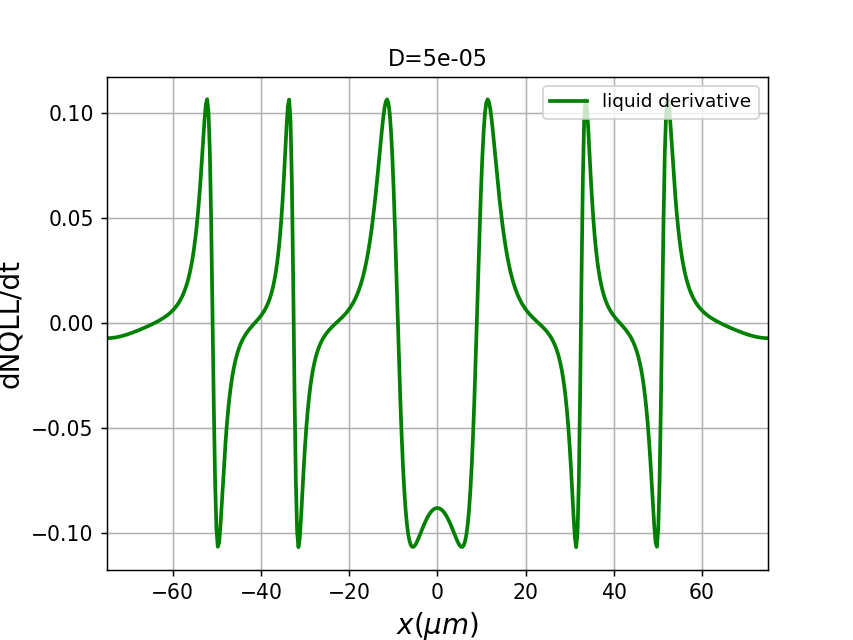

<IPython.core.display.Javascript object>


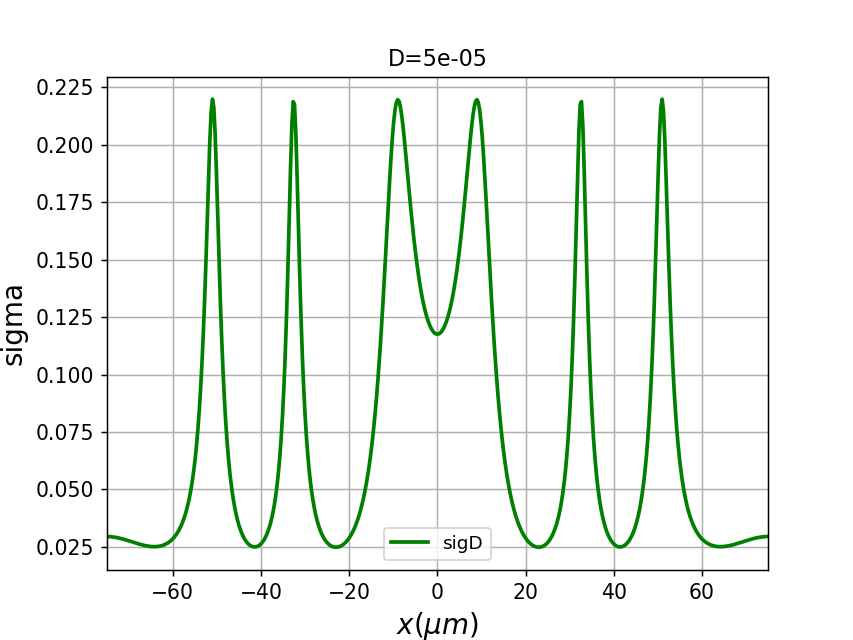

<IPython.core.display.Javascript object>


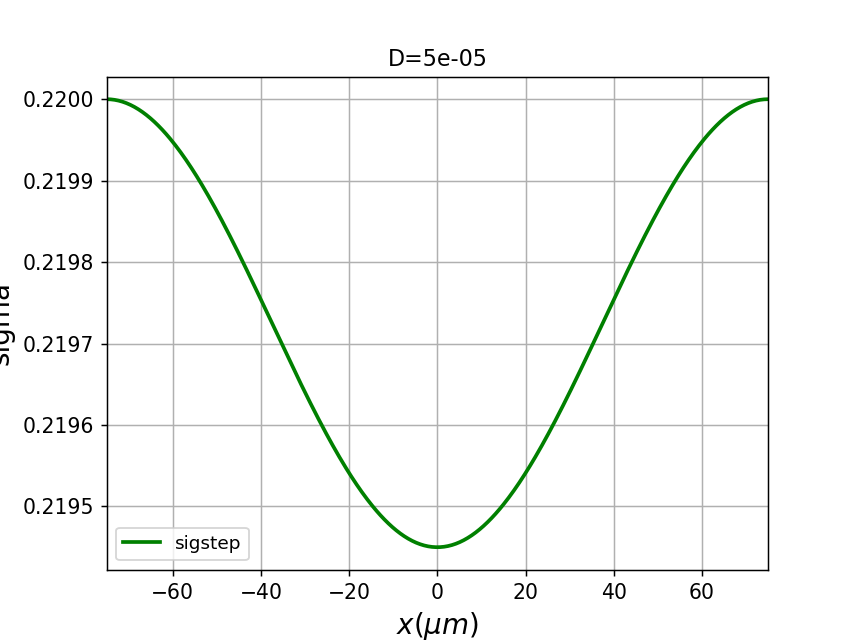

<IPython.core.display.Javascript object>


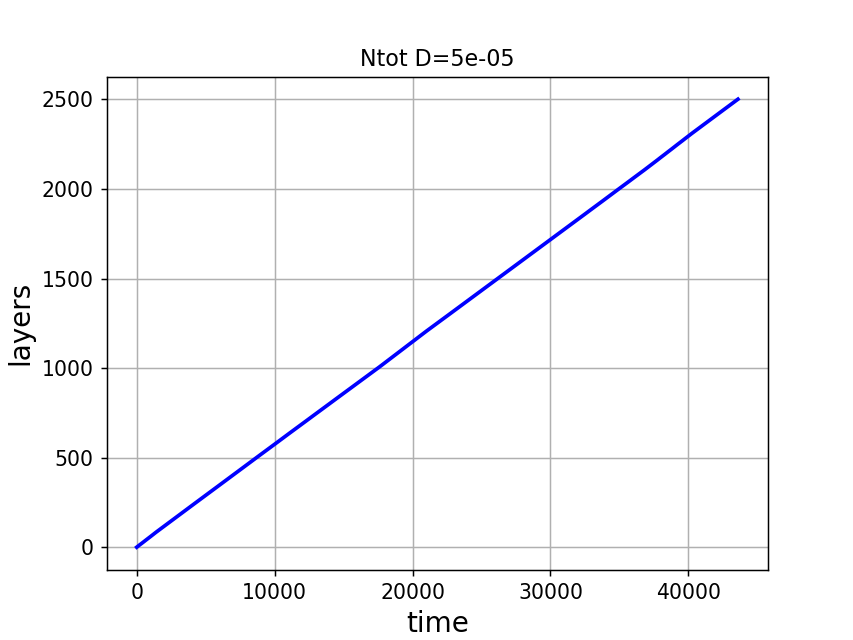

<IPython.core.display.Javascript object>


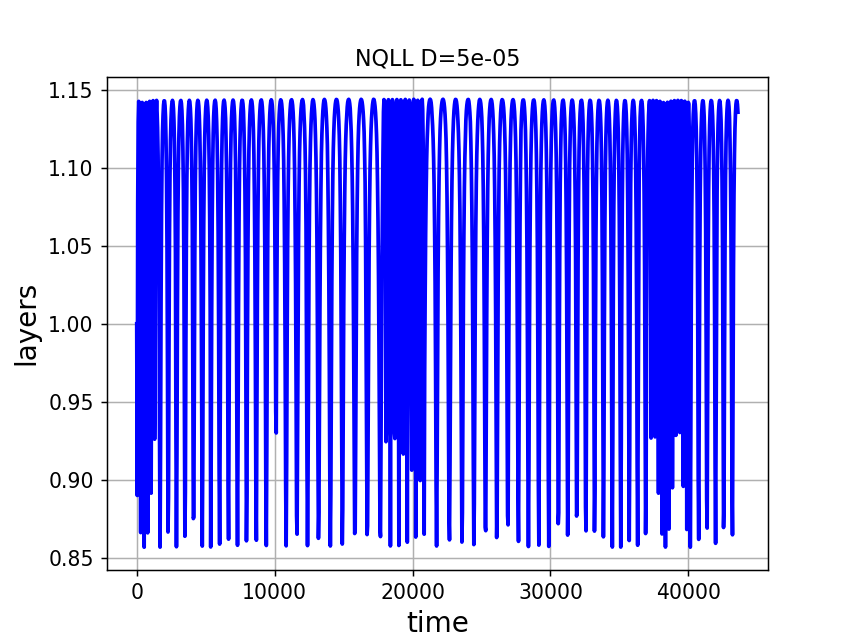

<IPython.core.display.Javascript object>


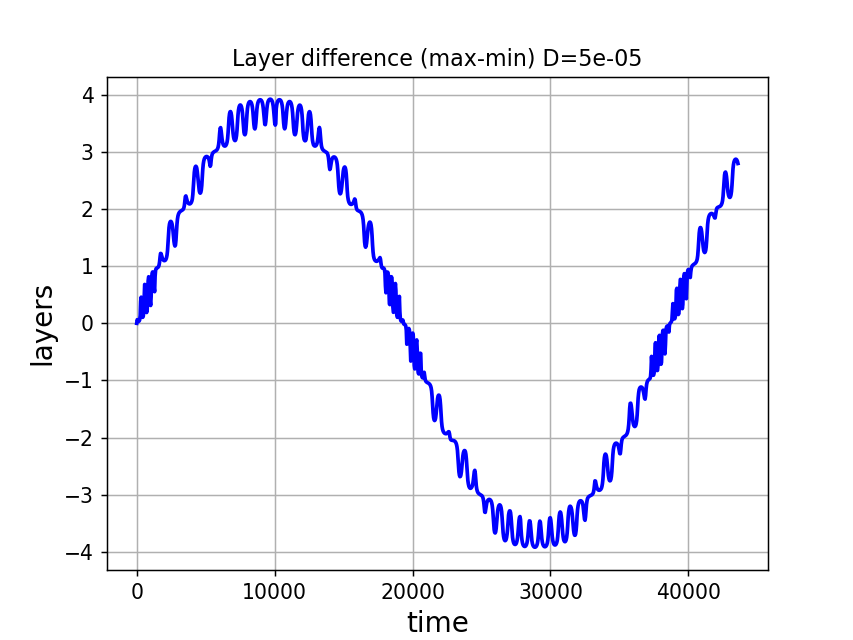

Text(0.5, 1.0, 'Layer difference (max-min) D=5e-05')

In [7]:
# Growth statistics
sec1 = time.time()

# minpoint = min(Nice)
minpoint = 0
ncorner = 4
print("Height of Ice", minpoint)
delta_Ntot_entire = Ntot-Ntotkeep[0]
print( "1-D growth, corner", delta_Ntot_entire[ncorner])
print( "1-D growth, center", delta_Ntot_entire[nmid])
growthrate_entire = delta_Ntot_entire/ttot*umpersec_over_mlyperus
print( "1-D Modeled growth rate, corner, um/s", growthrate_entire[ncorner])
print( "1-D Modeled growth rate, corner, ml/us", growthrate_entire[ncorner]/umpersec_over_mlyperus)
print( "1-D Modeled growth rate, center, um/s", growthrate_entire[nmid])
alpha = growthrate_entire/nu_kin/sigmaI
print( "1-D Modeled alpha, corner", alpha[ncorner])
print( "1-D Modeled alpha, center", alpha[nmid])
print( "Difference, %", (alpha[nmid]-alpha[ncorner])/alpha[ncorner]*100)


# Comparisons with 0-D model
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d/umpersec_over_mlyperus)
print( "0-D Modeled alpha", alpha_0d)
print( "Growth ratio 1D (corner)/0D", growthrate_entire[ncorner]/growthrate_0d)
print( "Growth ratio 1D (center)/0D", growthrate_entire[nmid]/growthrate_0d)
print( "Contribution of diffusion", (growthrate_entire[nmid]-growthrate_0d)/growthrate_0d*100, '%')

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmaIcorner)
print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmaIcorner)
print("Libbrecht's predicted alpha", alpha_L)

# Timing statistics
sec2 = time.time()
print("Time taken:", int((sec2-sec1)/60), "min", (sec2-sec1)%60, "secs")

title = 'D='+str(D)

# Plot ice and liquid
plt.figure()
plt.plot(x-xmid, Nice-minpoint, 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, NQLL+Nice-minpoint, 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice & liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot liquid only
plt.figure()
plt.plot(x-xmid, NQLL, 'g', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot derivatives
dydx = ds.f1d(ylast,0,params)
dydx = np.reshape(dydx,(2,nx))
plt.figure()
plt.plot(x-xmid, dydx[0,:], 'g', label='liquid derivative', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('dNQLL/dt',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot sigma_m
sigD = ds.f1d_sigma_m(ylast,0,params)
plt.figure()
plt.plot(x-xmid, sigD, 'g', label='sigD', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('sigma',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot sigma
plt.figure()
plt.plot(x-xmid, sigmaI, 'g', label='sigstep', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('sigma',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# The liquid over time
ix = 0
Ntotkeep_at_one_position = np.array(Ntotkeep)[:,ix]
plt.figure()
plt.plot(tkeep, Ntotkeep_at_one_position, 'b', label='total', lw=linewidth)
plt.xlabel('time',fontsize=fontsize)
plt.ylabel('layers',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.title('Ntot '+title)

# 
ix = 0
NQLLkeep_at_one_position = np.array(NQLLkeep)[:,ix]
plt.figure()
plt.plot(tkeep, NQLLkeep_at_one_position, 'b', label='liquid', lw=linewidth)
plt.xlabel('time',fontsize=fontsize)
plt.ylabel('layers',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.title('NQLL '+title)


Ntot_difference = np.array(Ntotkeep)[:,-1] - np.array(Ntotkeep)[:,nmid]
plt.figure()
plt.plot(tkeep, Ntot_difference, 'b', label='number of steps', lw=linewidth)
plt.xlabel('time',fontsize=fontsize)
plt.ylabel('layers',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.title('Layer difference (max-min) '+title)

### The cell below is just backup for parameters, and allows some exploration (but not part of the simulation)

In [8]:
# The time required for an initial gaussian to diffuse
layer_growth_rate = growthrate_0d/umpersec_over_mlyperus; print('Layer growth rate =', layer_growth_rate)
t1 = 1/layer_growth_rate; print('Time_to_add_a_layer =', t1)
t2 = 2.5**2/D; print('Time to diffuse across a terrace =', t2)
t3 = 0.2**2/D; print('Time to diffuse into a step =', t3)
t4 = 0.001; print('Time for ice-QLL equilibration =', t4)

# How a change in the crystal size could be used to calculate a new diffusion coefficient with the same D/dx^2
D_old = 2e-6
D_new = D_old/50**2*100**2; print(D_new)

# Computing the kinetic deposition velocity ... roughly, 260 
import numpy as np
M = 18 # g/mol
T = 260 # K
NA = 6.02e23
m = M/NA; print(m,'mass of a molecule of water, grams/mol')
m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
R = 8.314 # J/K-mol
k = R/NA; print(k,"Boltzmann's constant, J/K")

Pvap = 200 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
V_gas = R*T/Pvap # Must be in m^3
V_gas *= (10/1)**3; print(V_gas, 'Liters') 
V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
c_sat = 1/V_gas # mol/cm^3
c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
V_solid = 1/c_solid # cm^3/g

V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# Computing the kinetic deposition velocity ... roughly, 240 K has nukin of 40 um/s (we used 49 um/s in the paper)
M = 18 # g/mol
T = 240 # K
NA = 6.02e23
m = M/NA; print(m,'mass of a molecule of water, grams/mol')
m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
R = 8.314 # J/K-mol
k = R/NA; print(k,"Boltzmann's constant, J/K")

Pvap = 26 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
V_gas = R*T/Pvap # Must be in m^3
V_gas *= (10/1)**3; print(V_gas, 'Liters') 
V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
c_sat = 1/V_gas # mol/cm^3
c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
V_solid = 1/c_solid # cm^3/g

V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# Gladich et al recommendation
D_Gladich = 0.16e-9 # m^2/s
D_Gladich *= (1e6/1)**2*(1/1e6); print('Gladich says, for 260 K, D = ', D_Gladich)

Layer growth rate = 0.059541915483571774
Time_to_add_a_layer = 16.794891327873223
Time to diffuse across a terrace = 125000.0
Time to diffuse into a step = 800.0000000000001
Time for ice-QLL equilibration = 0.001
8e-06
2.990033222591362e-23 mass of a molecule of water, grams/mol
2.9900332225913625e-26 mass of a molecule of water, kg/mol
1.381063122923588e-23 Boltzmann's constant, J/K
10808.199999999999 Liters
10808199.999999998 cm^3
1.6654021946300035e-06 density of vapor, g/cm^3
0.92 density of ice, g/cm^3
9943543.999999998 ratio of volumes
1.810219776771743e-06 ratio of densities
0.0002502630900698087 kinetic velocity, m/s
250.26309006980867 kinetic velocity, um/s
2.990033222591362e-23 mass of a molecule of water, grams/mol
2.9900332225913625e-26 mass of a molecule of water, kg/mol
1.381063122923588e-23 Boltzmann's constant, J/K
76744.61538461539 Liters
76744615.38461539 cm^3
2.345441424103921e-07 density of vapor, g/cm^3
0.92 density of ice, g/cm^3
70605046.15384616 ratio of volumes